In [1]:
import os


import numpy as np
import torch
from torch import nn
import sys
os.chdir("..")

from src.models.plModel import LightningModel
from src.utils.OneSimDataloader import DataModule
from src.solvers.ode import simulation_forecast,SB_forecast
from pytorch_lightning.callbacks import ModelCheckpoint


import pytorch_lightning as pl

from pytorch_lightning import Trainer
from matplotlib.pyplot import cm
from matplotlib import ticker

In [ ]:
GPUS = 1
N_EPOCHS = 100

In [ ]:
def cli_main():
    pl.seed_everything(42)

   

    data_module = DataModule(batch_size=256,num_workers=40)
    data_module.setup()

   
    pl_model = LightningModel(updates_mean=data_module.updates_mean,updates_std=data_module.updates_std)

    if GPUS < 1:
        callbacks = None
    else:
        callbacks = [pl.callbacks.GPUStatsMonitor()]

    
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode='min', save_last=True)

    trainer = pl.Trainer(callbacks=callbacks, checkpoint_callback=checkpoint_callback, gpus=GPUS, max_epochs=N_EPOCHS,
                         )

    trainer.fit(pl_model,data_module)

    return data_module,pl_model,trainer


if __name__ == '__main__':
     _dm,_model, _trainer = cli_main()

In [2]:
data_module = DataModule(batch_size=256,num_workers=40)
data_module.setup()

Train Test Val Split Done
Testing Dataset starts here
(319086, 4)
Calculated tendencies
Testing Dataset starts here
(319086, 9)
Testing Dataset starts here
(319086, 6)
Inputs Created
Testing Dataset starts here
(319086, 4)
Created Outputs
Train Test Val Split Done


# Inference Part

In [16]:
pl_model = LightningModel(updates_mean=data_module.updates_mean,updates_std=data_module.updates_std)
new_model = pl_model.load_from_checkpoint("/gpfs/work/sharmas/mc-snow-data/lightning_logs/version_568275/checkpoints/epoch=78-step=9963005.ckpt")

In [17]:
x,updates,rates,y=data_module.test_dataset[:]

In [18]:
predictions_updates=new_model.forward(torch.from_numpy(x))

Text(0.5, 0.98, 'NWP vs ML (Updates)')

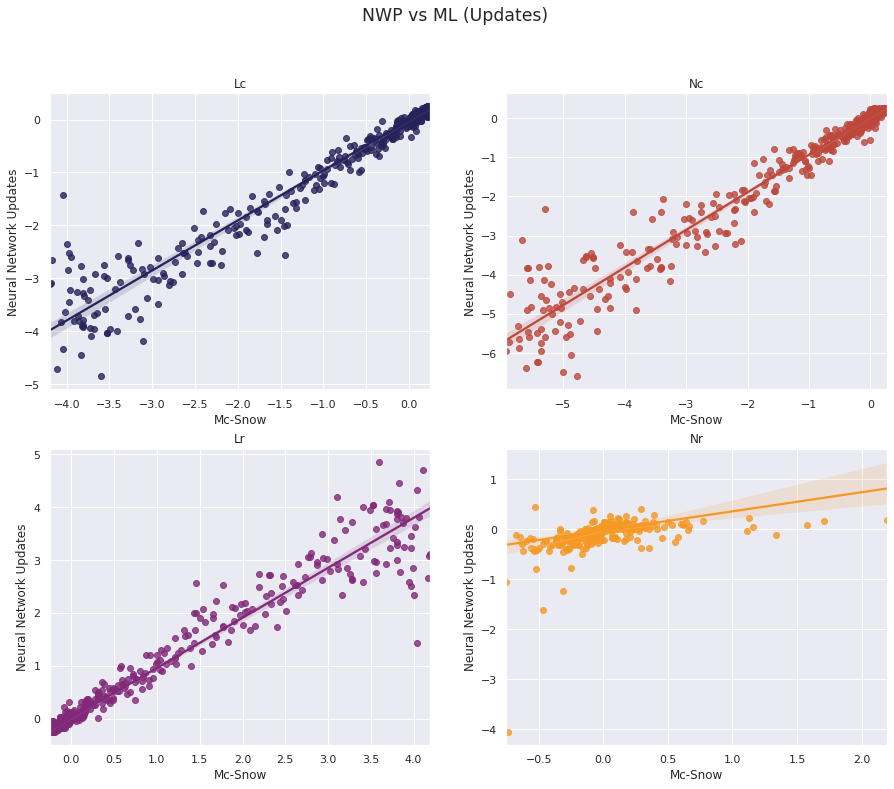

In [25]:
var=["Lc","Nc","Lr","Nr"]
c=["#26235b","#bc473a","#812878","#f69824"]
fig_size=[15,12]
sns.set_theme(style="darkgrid")
fig= plt.figure()
fig.set_size_inches(fig_size)

for i in range (4):
    ax = fig.add_subplot(2,2, i + 1)
    
    
   
    sns.regplot(x=updates[:1000,i],y=predictions_updates[:1000,i].detach().numpy(),color=c[i])
   
    plt.title(var[i])
    plt.ylabel("Neural Network Updates")
    plt.xlabel("Mc-Snow")
    

fig.suptitle("NWP vs ML (Updates)", fontsize="x-large")

Text(0.5, 0.98, 'Superdroplet vs ML (Moments)')

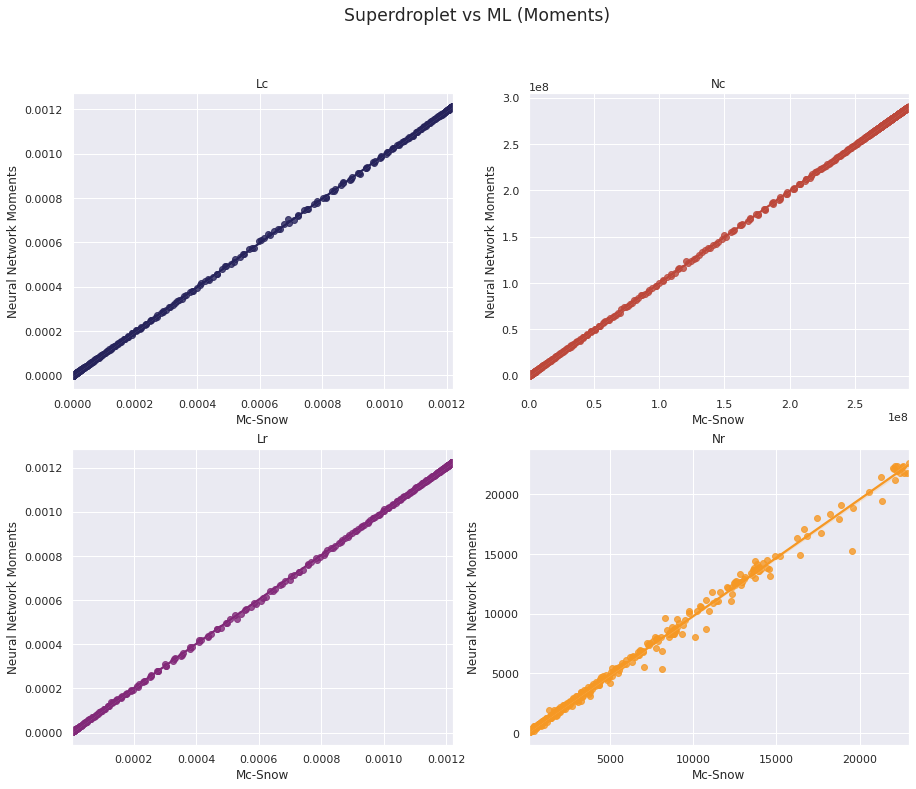

In [24]:
var=["Lc","Nc","Lr","Nr"]
c=["#26235b","#bc473a","#812878","#f69824"]
fig_size=[15,12]
sns.set_theme(style="darkgrid")
fig= plt.figure()
fig.set_size_inches(fig_size)
updates_orig=(predictions_updates.detach().numpy()*data_module.updates_std)+data_module.updates_mean
x_orig=(x[:,:4]*(data_module.outputs_std))+data_module.outputs_mean


preds=(updates_orig*20)+x_orig
outputs_orig=(y*data_module.outputs_std)+data_module.outputs_mean

for i in range (4):
    ax = fig.add_subplot(2,2, i + 1)
    
    
   
    sns.regplot(x=outputs_orig[:1000,i],y=preds[:1000,i],color=c[i])
   
    plt.title(var[i])
    plt.ylabel("Neural Network Moments")
    plt.xlabel("Mc-Snow")
    

fig.suptitle("Superdroplet vs ML (Moments)", fontsize="x-large")

In [9]:

def plot_simulation(predictions_orig,targets_orig,sb_preds,model_params,var_all):
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    var=['Lc','Nc','Lr','Nr']
    color=["#26235b","#bc473a","#812878","#f69824"]
    fig= plt.figure()
    fig.set_size_inches(13, 10)
    time= [x for x in range(0, len(predictions_orig))]
    #color=iter(cm.rainbow(np.linspace(0,1,4)))
    for i in range(4):
        ax = fig.add_subplot(2,2, i + 1)
        #c=next(color)
        plt.plot(time[:],predictions_orig[:,i],c=color[i])
        plt.plot(time[:],targets_orig[:,i],c='black')
        plt.plot(time[:-1],sb_preds[:,i],c=color[i],linestyle='dashed')
        plt.fill_between(time[:], targets_orig[:,i]-var_all[:len(time),i], targets_orig[:,i]+var_all[:len(time),i],facecolor = "gray")
        #plt.plot(time[:], targets_orig[:,i]-var_all[:len(time),i])
        plt.title(var[i])
        plt.xlabel('Timestep')    

        plt.legend(['Neural Network','Simulations','SB2001'])

   
    
    #fig.suptitle("Lo:{(model_params)[:,0]}; rm:{(model_params)[:,1]}; Nu:{model_params[:,2]}", fontsize="x-large")
    
    
    fig.suptitle("Lo: %.4f; rm:%.6f ; Nu: %.1f"%((model_params)[:,0],(model_params)[:,1],(model_params)[:,2]), fontsize="x-large")
    plt.show()

In [13]:
k=data_module.arr

In [11]:
with np.load('/gpfs/work/sharmas/mc-snow-data/big_box.npz') as npz:
        all_arr = np.ma.MaskedArray(**npz)
        
all_arr=all_arr.astype(np.float32)

In [12]:
def calc_errors(all_arr,n):

    var_1=np.std(all_arr[:,1,n,:],axis=-1)
    var_2=np.std(all_arr[:,2,n,:],axis=-1)
    var_3=np.std(all_arr[:,4,n,:],axis=-1)
    var_4=np.std(all_arr[:,5,n,:],axis=-1)
    var_all=np.concatenate((var_1.reshape(1,-1),var_2.reshape(1,-1),var_3.reshape(1,-1),var_4.reshape(1,-1)),axis=0)
    return var_all

In [13]:
arr=np.median(all_arr,axis=-1)

/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [33]:
new_forecast.orig

array([[1.5979300e-03, 5.2359901e+08, 0.0000000e+00, 0.0000000e+00],
       [1.5979300e-03, 5.2322301e+08, 0.0000000e+00, 0.0000000e+00],
       [1.5979300e-03, 5.2287098e+08, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.6702301e-10, 3.3297748e+02, 1.5979300e-03, 1.6015350e+01],
       [1.6066301e-10, 3.2297049e+02, 1.5979300e-03, 1.5990000e+01],
       [1.5456150e-10, 3.1325348e+02, 1.5979300e-03, 1.5962950e+01]],
      dtype=float32)

(3599, 16, 819)


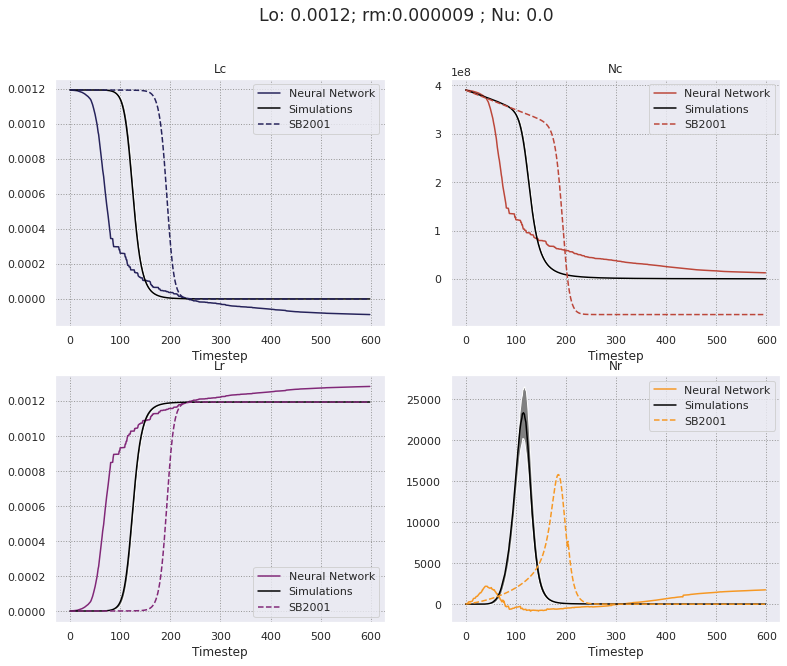

In [23]:
#arr=data_module.holdout_arr
#arr=data_module.arr.squeeze()
#arr=all_arr[:,:,:,9]
#import timeit

#start = timeit.default_timer()


sim_num=567
new_forecast=simulation_forecast(arr,new_model,sim_num, data_module)
new_forecast.test()
#stop = timeit.default_timer()

#print('Time: ', stop - start) 

sb_forecast=SB_forecast(arr,sim_num)
sb_forecast.SB_calc()
predictions_sb=np.asarray(sb_forecast.predictions).reshape(-1,4)
var_all=np.transpose(calc_errors(all_arr,sim_num))
plot_simulation(np.asarray(new_forecast.moment_preds).reshape(-1,4),new_forecast.orig,predictions_sb,new_forecast.model_params.reshape(1,-1),2*var_all)

In [70]:
var_all

masked_array(
  data=[[5.57283736e-08, 5.57283736e-08, 5.57283736e-08, 5.57283736e-08],
        [5.57283736e-08, 5.57283736e-08, 5.57283736e-08, 5.57283736e-08],
        [5.58004886e-08, 5.61569697e-08, 5.78756645e-08, 5.82902103e-08],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
  mask=False,
  fill_value=1e+20)

In [67]:
targets_orig=np.asarray(new_forecast.moment_preds).reshape(-1,4)

In [68]:
i=0
(targets_orig[:,i]-var_all[:targets_orig.shape[0],i]).shape

(3599,)

In [101]:
new_forecast.model_params.reshape(1,-1).shape

(1, 3)

In [102]:
np.concatenate((new_forecast.sim_data.reshape(1,-1),new_forecast.model_params.reshape(1,-1)),axis=1)

masked_array(data=[[1.5970905e-03, 2.2066595e+08, 0.0000000e+00,
                    0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
                    0.0000000e+00, 0.0000000e+00, 1.9123598e+04,
                    0.0000000e+00, 1.0508400e+05, 1.5999997e-03,
                    1.2000000e-05, 1.0000000e+00, 1.0000000e+00,
                    1.5999997e-03, 1.2000000e-05, 1.0000000e+00]],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [264]:
with np.load('/gpfs/work/sharmas/mc-snow-data/big_box.npz') as npz:
            arr = np.ma.MaskedArray(**npz)

In [265]:
arr=np.mean(arr[:,:,:,:],axis=-1)

In [256]:
arr.shape

(3599, 18, 819)

In [260]:
all_id=np.random.permutation(arr.shape[-1])
test_id=all_id[:100]
train_id=all_id[100:]

In [261]:
holdout_arr=arr[:,:,test_id]

In [262]:
arr=arr[:,:,train_id]

In [263]:
arr.shape

(3599, 18, 0)